In [1]:
!pip install kaggle

In [2]:
import os

# Ensure the kaggle.json is placed in the correct location
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Command to download the Diabetes Health Indicators dataset
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset --unzip

# Command to download the Diabetes Dataset (Genetic and Environmental Factors)
!kaggle datasets download -d ankitbatra1210/diabetes-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0




  0%|          | 0.00/6.03M [00:00<?, ?B/s]
 17%|#6        | 1.00M/6.03M [00:01<00:08, 650kB/s]
 33%|###3      | 2.00M/6.03M [00:01<00:03, 1.31MB/s]
 50%|####9     | 3.00M/6.03M [00:01<00:01, 2.10MB/s]
 66%|######6   | 4.00M/6.03M [00:02<00:00, 2.99MB/s]
 83%|########2 | 5.00M/6.03M [00:02<00:00, 3.90MB/s]
 99%|#########9| 6.00M/6.03M [00:02<00:00, 4.87MB/s]
100%|##########| 6.03M/6.03M [00:02<00:00, 2.70MB/s]


Dataset URL: https://www.kaggle.com/datasets/ankitbatra1210/diabetes-dataset
License(s): CC0-1.0




  0%|          | 0.00/2.35M [00:00<?, ?B/s]
 43%|####2     | 1.00M/2.35M [00:01<00:02, 626kB/s]
 85%|########5 | 2.00M/2.35M [00:01<00:00, 1.26MB/s]
100%|##########| 2.35M/2.35M [00:01<00:00, 1.25MB/s]


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# Load datasets (assuming they have been downloaded and unzipped)
diabetes_health_df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_genetic_df = pd.read_csv("diabetes_dataset00.csv")
epigenetic_df = pd.read_csv("epigenetic_hypoglycemia_dataset.csv")

In [3]:
# Data Preprocessing
# Transform diabetes_genetic_df
diabetes_genetic_df['Diabetes_binary'] = diabetes_genetic_df['Target'].apply(lambda x: 1 if 'Diabet' in x.lower() else 0)
diabetes_genetic_df['HvyAlcoholConsump'] = diabetes_genetic_df['Alcohol Consumption'].apply(lambda x: 1 if x == 'Heavy' else 0)
diabetes_genetic_df['HighBP'] = diabetes_genetic_df['Blood Pressure'].apply(lambda x: 1 if x > 130 else 0)
diabetes_genetic_df['Smoker'] = diabetes_genetic_df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0)
diabetes_genetic_df['PhysActivity'] = diabetes_genetic_df['Physical Activity'].apply(lambda x: 1 if x == 'Active' else 0)

In [4]:
# Transform epigenetic_df
epigenetic_df['Diabetes_binary'] = epigenetic_df['hypoglycemia_risk'].apply(lambda x: 1 if x > 0 else 0)
epigenetic_df['Male'] = epigenetic_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
epigenetic_df['Hypoglycemia'] = epigenetic_df['hypoglycemia_events'].apply(lambda x: 1 if x > 0 else 0)
epigenetic_df['HighInsulinSensitivity'] = epigenetic_df['insulin_sensitivity'].apply(lambda x: 1 if x > 0.5 else 0)
epigenetic_df['rs10830963_risk'] = epigenetic_df['rs10830963'].apply(lambda x: 1 if x == 'Risk' else 0)

In [5]:
# Standardizing column names for all datasets
diabetes_genetic_df.rename(columns={'Age': 'age', 'BMI': 'bmi'}, inplace=True)
diabetes_health_df.rename(columns={'Age': 'age', 'BMI': 'bmi'}, inplace=True)

In [6]:
# Keep only the relevant columns from each dataset
columns_to_keep_genetic = ['age', 'bmi', 'HvyAlcoholConsump', 'Smoker', 'HighBP', 'PhysActivity', 'Diabetes_binary']
columns_to_keep_health = ['age', 'bmi', 'HvyAlcoholConsump', 'Smoker', 'HighBP', 'PhysActivity', 'Diabetes_binary']
columns_to_keep_epigenetic = ['age', 'bmi', 'Hypoglycemia', 'Male', 'HighInsulinSensitivity', 'rs10830963_risk', 'Diabetes_binary']

In [7]:
# Subset the data
cleaned_diabetes_genetic_df = diabetes_genetic_df[columns_to_keep_genetic]
cleaned_diabetes_health_df = diabetes_health_df[columns_to_keep_health].astype(int)
cleaned_epigenetic_df = epigenetic_df[columns_to_keep_epigenetic]

In [8]:
# Combine datasets
half_df_genetic = cleaned_diabetes_genetic_df.sample(frac=0.5, random_state=42)
half_df_health = cleaned_diabetes_health_df.sample(frac=0.5, random_state=42)
half_df_epigenetic = cleaned_epigenetic_df.sample(frac=0.5, random_state=42)

In [9]:
# Concatenate datasets
combined_dataset = pd.concat([half_df_genetic, half_df_health, half_df_epigenetic], axis=0)

# Fill missing values
combined_dataset.fillna(0, inplace=True)

In [10]:
combined_dataset.head()

,age,bmi,HvyAlcoholConsump,Smoker,HighBP,PhysActivity,Diabetes_binary,Hypoglycemia,Male,HighInsulinSensitivity,rs10830963_risk
46730,54,32.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
48393,74,32.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
41416,57,27.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
34506,30,39.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
43725,28,21.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [11]:
# Drop 'Diabetes_binary' as the target column and separate features and target
X = combined_dataset.drop('Diabetes_binary', axis=1)
y = combined_dataset['Diabetes_binary']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8348158443363447
Confusion Matrix:
 [[9672 1068]
 [1309 2341]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89     10740
           1       0.69      0.64      0.66      3650

    accuracy                           0.83     14390
   macro avg       0.78      0.77      0.78     14390
weighted avg       0.83      0.83      0.83     14390



C:\Users\srish\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Model Optimization
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8474
ROC-AUC: 0.9102
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     10740
           1       0.69      0.71      0.70      3650

    accuracy                           0.85     14390
   macro avg       0.80      0.80      0.80     14390
weighted avg       0.85      0.85      0.85     14390



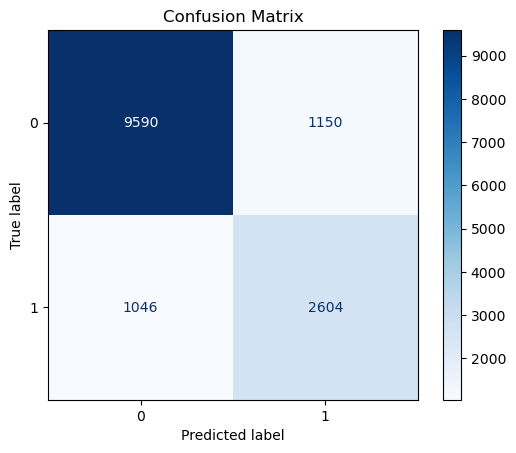

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Gradient Boosting Accuracy: 0.8664
Gradient Boosting ROC-AUC: 0.9333
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86     10872
           1       0.82      0.93      0.87     10669

    accuracy                           0.87     21541
   macro avg       0.87      0.87      0.87     21541
weighted avg       0.87      0.87      0.87     21541



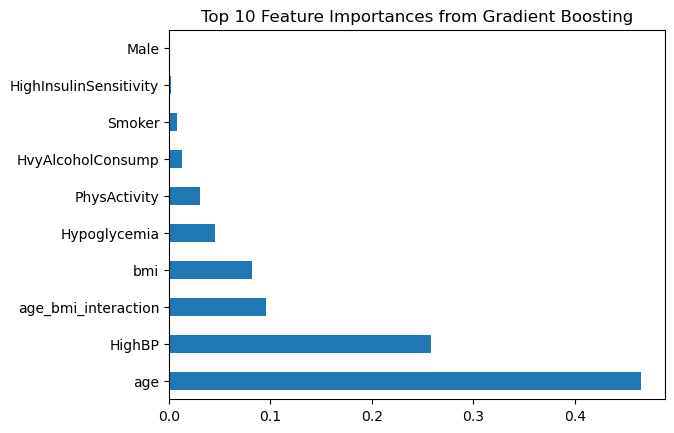

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 43182, number of negative: 42979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 86161, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501178 -> initscore=0.004712
[LightGBM] [Info] Start training from score 0.004712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

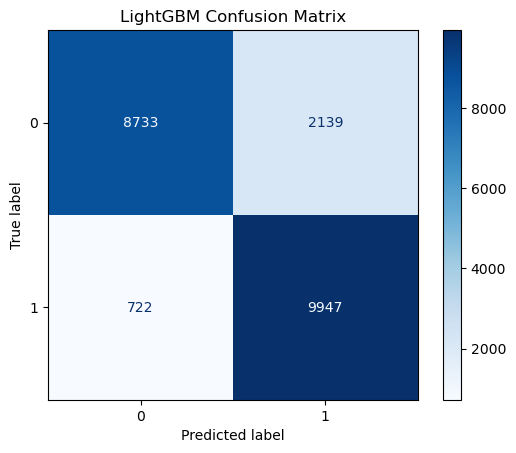

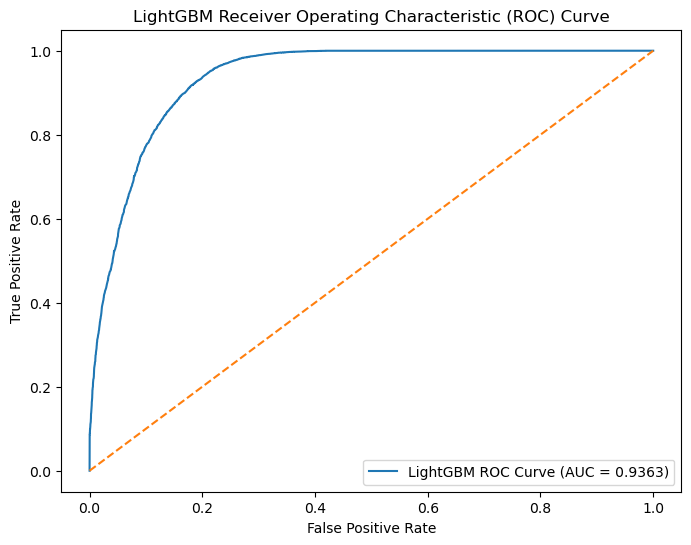

In [18]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set Kaggle config path (optional, if you're using Kaggle)
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Load datasets (assuming they have been downloaded and unzipped)
diabetes_health_df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_genetic_df = pd.read_csv("diabetes_dataset00.csv")
epigenetic_df = pd.read_csv("epigenetic_hypoglycemia_dataset.csv")

# Data Preprocessing
# Transform diabetes_genetic_df
diabetes_genetic_df['Diabetes_binary'] = diabetes_genetic_df['Target'].apply(lambda x: 1 if 'Diabet' in x.lower() else 0)
diabetes_genetic_df['HvyAlcoholConsump'] = diabetes_genetic_df['Alcohol Consumption'].apply(lambda x: 1 if x == 'Heavy' else 0)
diabetes_genetic_df['HighBP'] = diabetes_genetic_df['Blood Pressure'].apply(lambda x: 1 if x > 130 else 0)
diabetes_genetic_df['Smoker'] = diabetes_genetic_df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0)
diabetes_genetic_df['PhysActivity'] = diabetes_genetic_df['Physical Activity'].apply(lambda x: 1 if x == 'Active' else 0)

# Transform epigenetic_df
epigenetic_df['Diabetes_binary'] = epigenetic_df['hypoglycemia_risk'].apply(lambda x: 1 if x > 0 else 0)
epigenetic_df['Male'] = epigenetic_df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
epigenetic_df['Hypoglycemia'] = epigenetic_df['hypoglycemia_events'].apply(lambda x: 1 if x > 0 else 0)
epigenetic_df['HighInsulinSensitivity'] = epigenetic_df['insulin_sensitivity'].apply(lambda x: 1 if x > 0.5 else 0)
epigenetic_df['rs10830963_risk'] = epigenetic_df['rs10830963'].apply(lambda x: 1 if x == 'Risk' else 0)

# Standardizing column names for all datasets
diabetes_genetic_df.rename(columns={'Age': 'age', 'BMI': 'bmi'}, inplace=True)
diabetes_health_df.rename(columns={'Age': 'age', 'BMI': 'bmi'}, inplace=True)

# Keep only the relevant columns from each dataset
columns_to_keep_genetic = ['age', 'bmi', 'HvyAlcoholConsump', 'Smoker', 'HighBP', 'PhysActivity', 'Diabetes_binary']
columns_to_keep_health = ['age', 'bmi', 'HvyAlcoholConsump', 'Smoker', 'HighBP', 'PhysActivity', 'Diabetes_binary']
columns_to_keep_epigenetic = ['age', 'bmi', 'Hypoglycemia', 'Male', 'HighInsulinSensitivity', 'rs10830963_risk', 'Diabetes_binary']

# Subset the data
cleaned_diabetes_genetic_df = diabetes_genetic_df[columns_to_keep_genetic]
cleaned_diabetes_health_df = diabetes_health_df[columns_to_keep_health].astype(int)
cleaned_epigenetic_df = epigenetic_df[columns_to_keep_epigenetic]

# Combine datasets
half_df_genetic = cleaned_diabetes_genetic_df.sample(frac=0.5, random_state=42)
half_df_health = cleaned_diabetes_health_df.sample(frac=0.5, random_state=42)
half_df_epigenetic = cleaned_epigenetic_df.sample(frac=0.5, random_state=42)

# Concatenate datasets
combined_dataset = pd.concat([half_df_genetic, half_df_health, half_df_epigenetic], axis=0)

# Fill missing values
combined_dataset.fillna(0, inplace=True)

# Adding interaction features: age * bmi
combined_dataset['age_bmi_interaction'] = combined_dataset['age'] * combined_dataset['bmi']

# Drop 'Diabetes_binary' as the target column and separate features and target
X = combined_dataset.drop('Diabetes_binary', axis=1)
y = combined_dataset['Diabetes_binary']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])

print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_gb:.4f}")
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

# Feature importance based on Gradient Boosting
feature_importances_gb = gb_model.feature_importances_
important_features = pd.Series(feature_importances_gb, index=X.columns).nlargest(10)
important_features.plot(kind='barh')
plt.title('Top 10 Feature Importances from Gradient Boosting')
plt.show()

# LightGBM Classifier with GridSearchCV
lgbm_model = LGBMClassifier(random_state=42)
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5, n_jobs=-1, verbose=2)
grid_search_lgbm.fit(X_train, y_train)

# Best LightGBM Model
best_lgbm_model = grid_search_lgbm.best_estimator_
print(f"Best LightGBM parameters: {grid_search_lgbm.best_params_}")

# Evaluate LightGBM
y_pred_lgbm = best_lgbm_model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])

print(f"LightGBM Accuracy: {accuracy_lgbm:.4f}")
print(f"LightGBM ROC-AUC: {roc_auc_lgbm:.4f}")
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm))

# Confusion Matrix for LightGBM
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.show()

# Plot ROC Curve for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgbm:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

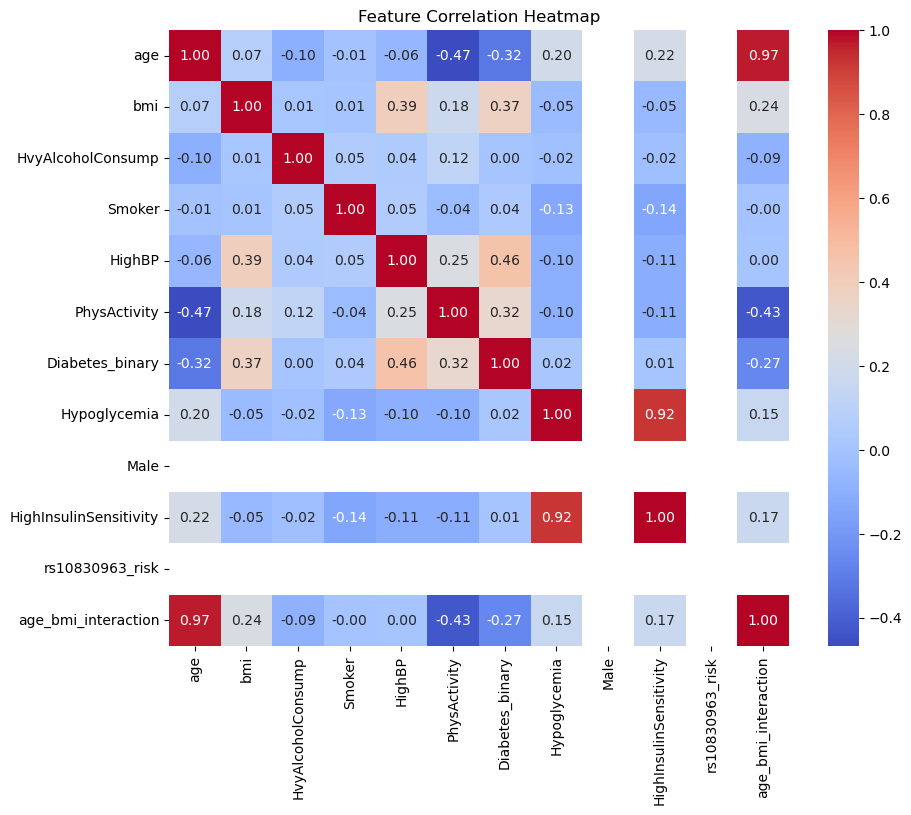

In [19]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(combined_dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


100%|===================| 21534/21541 [04:47<00:00]        

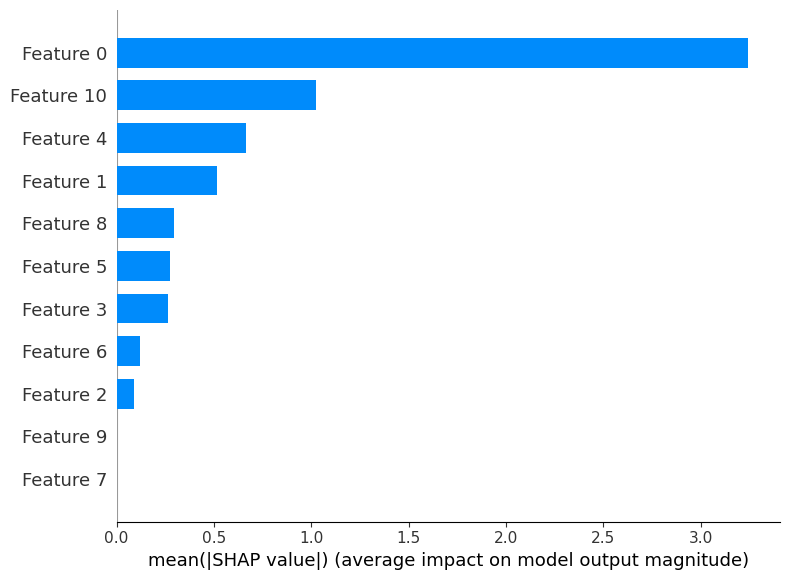

In [22]:
import shap

explainer = shap.Explainer(best_lgbm_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


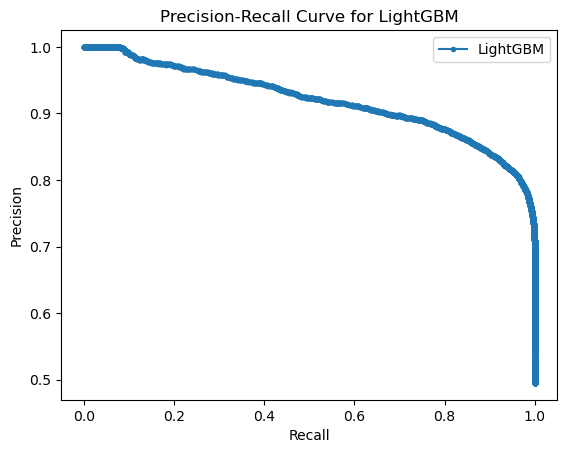

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LightGBM')
plt.legend()
plt.show()


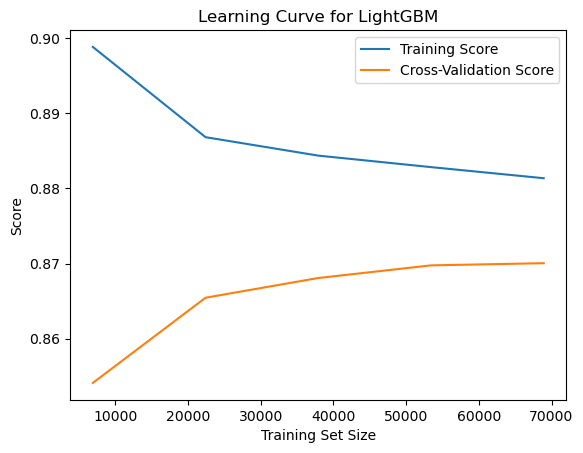

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_lgbm_model, X_train, y_train, cv=5, n_jobs=-1)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.title("Learning Curve for LightGBM")
plt.legend()
plt.show()
